# 1 - Perkenalan

Megatheo Justino Rumahorbo 

FTDS Batch 11 Phase 1

Dataset : Open University Learning Analytics 

Data diambil dari UCI Machine Learning Repository
- https://archive.ics.uci.edu/ml/datasets/Open+University+Learning+Analytics+dataset

Data ini merepresentasikan info data student berdasarkan demograpic mereka yang mempengaruhi kelulusan dari student

Objective :
- Membuat model Classification untuk memprediksi student lulus dari module.
- Insight dari data

Data Desc:

- code_module – an identification code for a module on which the student is registered.
- code_presentation - the identification code of the presentation during which the student is registered on the module.
- id_student – a unique identification number for the student.
- gender – the student’s gender.
- region – identifies the geographic region, where the student lived while taking the module-presentation.
- highest_education – highest student education level on entry to the module presentation.
- imd_band – specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation.
- age_band – band of the student’s age.
- num_of_prev_attempts – the number times the student has attempted this module.
- studied_credits – the total number of credits for the modules the student is currently studying.
- disability – indicates whether the student has declared a disability.
- final_result – student’s final result in the module-presentation.

# 2 - Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, make_scorer, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV





# 3 - Data Loading

In [2]:
# Load Data
data = pd.read_csv('studentInfo.csv')
data.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


Colom yang akan menjadi target kita adalah kolom **final_result** sebelum itu mari kita cek nilai dari kolom tersebut

In [3]:
# Check target unique values
data['final_result'].unique()

array(['Pass', 'Withdrawn', 'Fail', 'Distinction'], dtype=object)

Terdapat 4 class pada column tersebut, untuk itu kita akan memilih hanya 2 class dari data tersebut karena kita hanya akan memprediksi apakah student lulus atau tidak.

In [4]:
# filter data
df = data[(data['final_result'] == 'Pass') |
    (data['final_result'] == 'Fail')]

# reset index
df.reset_index(drop=True, inplace=True)

In [5]:
for i in df:    
    print(i, ':', df[df[i] == '?'])
    print('============================================================')

code_module : Empty DataFrame
Columns: [code_module, code_presentation, id_student, gender, region, highest_education, imd_band, age_band, num_of_prev_attempts, studied_credits, disability, final_result]
Index: []
code_presentation : Empty DataFrame
Columns: [code_module, code_presentation, id_student, gender, region, highest_education, imd_band, age_band, num_of_prev_attempts, studied_credits, disability, final_result]
Index: []
id_student : Empty DataFrame
Columns: [code_module, code_presentation, id_student, gender, region, highest_education, imd_band, age_band, num_of_prev_attempts, studied_credits, disability, final_result]
Index: []
gender : Empty DataFrame
Columns: [code_module, code_presentation, id_student, gender, region, highest_education, imd_band, age_band, num_of_prev_attempts, studied_credits, disability, final_result]
Index: []
region : Empty DataFrame
Columns: [code_module, code_presentation, id_student, gender, region, highest_education, imd_band, age_band, num_of_pre

In [6]:
# Detect Outliers
outliers = df[df['imd_band'] == '?']
print(len(outliers))
print(len(outliers)/len(df)*100)


676
3.4822026477102974


In [7]:
# Drop Outliers_train
df.drop(outliers.index, inplace=True)

C:\Users\mjrum\AppData\Local\Temp\ipykernel_9548\3427843545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outliers.index, inplace=True)


In [8]:
# Check Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18737 entries, 0 to 19412
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           18737 non-null  object
 1   code_presentation     18737 non-null  object
 2   id_student            18737 non-null  int64 
 3   gender                18737 non-null  object
 4   region                18737 non-null  object
 5   highest_education     18737 non-null  object
 6   imd_band              18737 non-null  object
 7   age_band              18737 non-null  object
 8   num_of_prev_attempts  18737 non-null  int64 
 9   studied_credits       18737 non-null  int64 
 10  disability            18737 non-null  object
 11  final_result          18737 non-null  object
dtypes: int64(3), object(9)
memory usage: 1.9+ MB


Setelah kita memilih target kita , kita bisa melihat bahwa terdapat 19413 baris dan 11 kolom . Semua attribut adalah object kecuali kolom **id_student**, **num_of_prev_attempts**, dan **studied_credits**. Terlihat juga bahwa semua colum terisi sesui dengan banyaknya baris yang mengindikasi tidak ada Missing Values. 

Notice pada kolom age_band yang seharusnya angka namun merupakan data categoric. Kita akan cek unique values pada kolom tersebut.

In [9]:
# Check Unique Values
df['age_band'].unique()

array(['55<=', '35-55', '0-35'], dtype=object)

Ternyata data ini merepresentasikan umur siswa dalam bentuk categoric dengan 3 level scala yaitu **0-35**, **35-55**, dan **55<=**.

Mari kita lihat Kolom yang numerical.

In [10]:
# Check Numerical Data
df.describe()

,id_student,num_of_prev_attempts,studied_credits
count,1.873700e+04,18737.000000,18737.000000
mean,6.982824e+05,0.167583,74.852164
std,5.461321e+05,0.485584,37.190253
min,6.516000e+03,0.000000,30.000000
25%,5.027630e+05,0.000000,60.000000
50%,5.865500e+05,0.000000,60.000000
75%,6.348240e+05,0.000000,90.000000
max,2.710343e+06,6.000000,630.000000


id_student, mungkin berfungsi sebagai index, karena pada dasarnya setiap student pasti berbeda idnya

number_of_prev_attempts, terlihat dari 25%, 50%, dan 75% quartile bernilai 0 dimana bisa diasumsikan student baru pertama kali mengikuti module namun terdappat juga student yang sudah 6 kali mengambil modul tertentu terlihat dari nilai maxnya

studied_credits, student memiliki rata-rata 74 credit , yang dangat jauh dari student yang memiliki credits tertinggi yaitu 630.

Mari kita cek apakah terdapat baris yang terduplikat pada data ini.

In [11]:
# Cek Duplicate
df.duplicated().sum()

0

Tidak terdapat baris yang terduplikat, terkahir kita tidak akan menggunakan kolom **id_student** karena berfungsi sebagai index

In [12]:
df.drop(columns='id_student', inplace=True)

C:\Users\mjrum\AppData\Local\Temp\ipykernel_9548\577864619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='id_student', inplace=True)


# 4 - EDA

Karena target kita adalah kolom **final_result**  kita akan melihat berapa banyak student yang lulus dan yang tidak

Pass    11830
Fail     6907
Name: final_result, dtype: int64


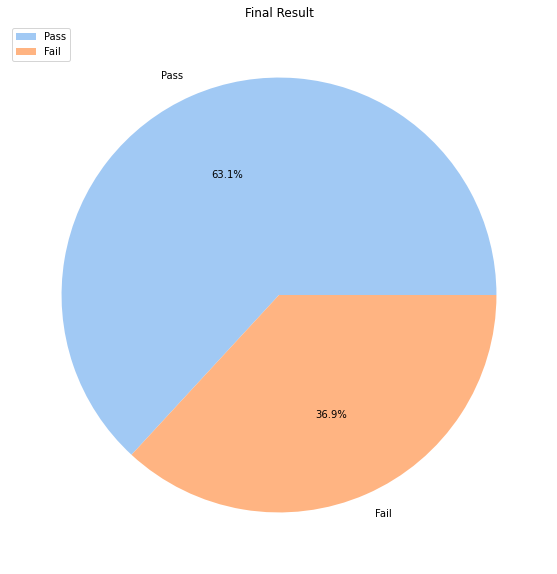

In [13]:
# filter data
final_result = df['final_result'].value_counts()
print(final_result)
# plot data
plt.figure(figsize=(20,10))

colors = sns.color_palette('pastel')[0:5]
plt.pie(final_result, labels=final_result.index, colors=colors, autopct='%1.1f%%')
plt.title('Final Result')
plt.legend(final_result.index, loc='upper left')
plt.show()

Terlihat perbedaan yang lumayan signifikan antara student yang lulus dengan yang tidak dimana student yang lulus ada 63,7% dan student yang tidak lulus terdapat 36,3%. 

Mari kita liat bagaimana data disetiap kolom.

## Univariate analysis: numerical data

In [14]:
# Create statistics summaries with skew, mean, and median
# Produce a dataframe with just numerical columns
df_num = df.select_dtypes(include=np.number)

for col in df_num.columns:

    skew = df_num[col].skew()
    mean = df_num[col].mean()
    median = df_num[col].median()
    
    print(f'\tSummary for {col.upper()}')
    print(f'Skewness of {col}\t: {skew}')
    print(f'Mean {col} :\t {mean}')
    print(f'Median {col} :\t {median} \n')

	Summary for NUM_OF_PREV_ATTEMPTS
Skewness of num_of_prev_attempts	: 3.7104249284886763
Mean num_of_prev_attempts :	 0.1675828574478305
Median num_of_prev_attempts :	 0.0 

	Summary for STUDIED_CREDITS
Skewness of studied_credits	: 1.8001567696727703
Mean studied_credits :	 74.85216416715589
Median studied_credits :	 60.0 



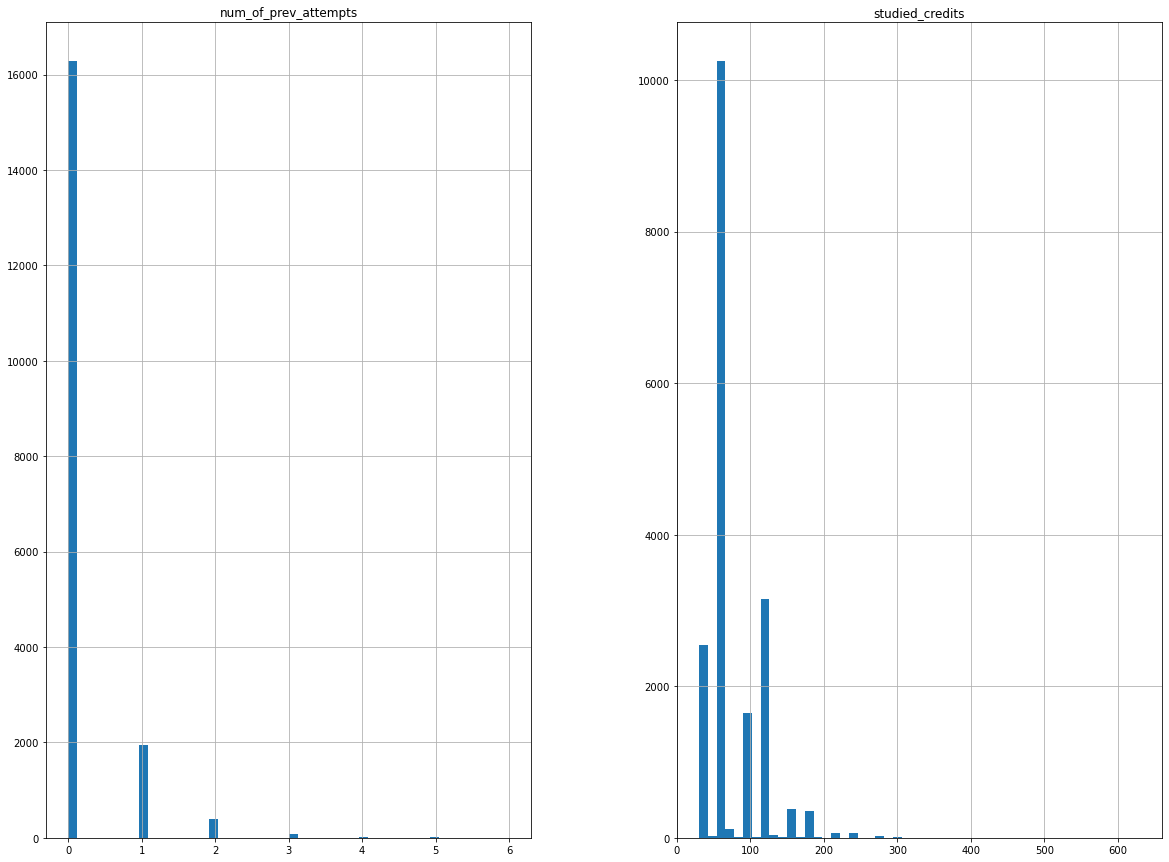

In [15]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Untuk kolom numerik ternyata berdistribusi skew terlihatt data berkumpul disebelah kiri. Mayoritas student juga merupakan student yang baru pertama kali mengambil module yang mereka ambil . Credit student mayoritas juga berada pada range 0 - 200.

## Univariate analysis: categorical data

In [16]:
# Produce a dataframe with just categorical columns
df_cat = df.select_dtypes(exclude=np.number)

df_cat.head()

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability,final_result
0,AAA,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,N,Pass
1,AAA,2013J,F,Scotland,HE Qualification,20-30%,35-55,N,Pass
2,AAA,2013J,F,South East Region,A Level or Equivalent,50-60%,35-55,N,Pass
3,AAA,2013J,F,West Midlands Region,Lower Than A Level,50-60%,0-35,N,Pass
4,AAA,2013J,M,Wales,A Level or Equivalent,80-90%,35-55,N,Pass


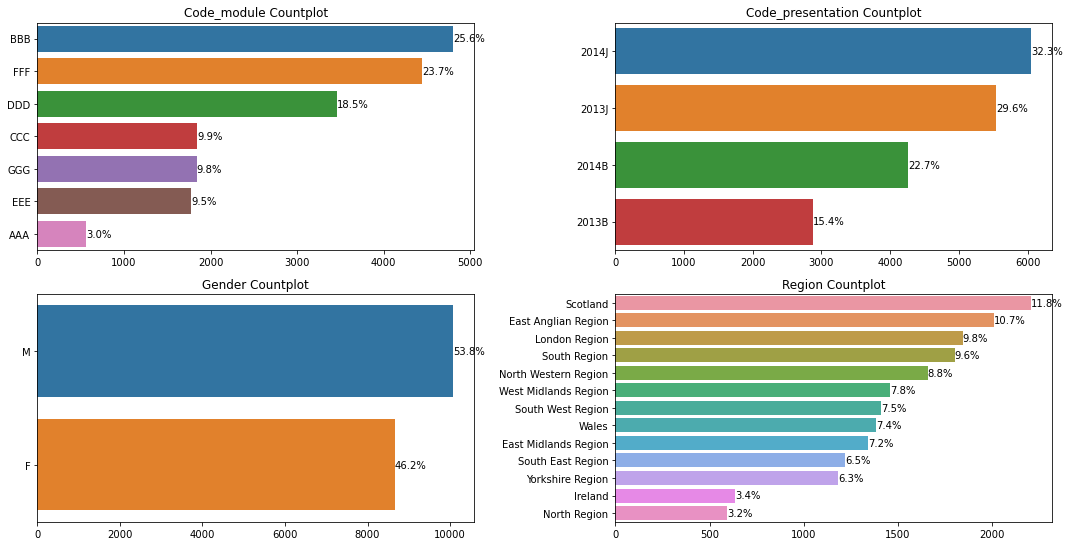

In [17]:
# Set the plot number for the first subplot function
plot_number = 1

# Set sizes for all plots
plt.figure(figsize=(15, 15)) # create a figure object
plt.subplots_adjust(hspace = 0.5) # set the size of subplots

for col in df_cat[['code_module', 'code_presentation', 'gender', 'region']]:
    
    # Call countplot on each column
    plt.subplot(4, 2, plot_number)
    sns.countplot(
        y=col,
        data=df_cat,
        order=df_cat[col].value_counts().index
    )
    plt.title(f'{col.capitalize()} Countplot')
    plt.xlabel('')
    plt.ylabel('')

    plot_number = plot_number + 1 # set a new plot number for the next subplot function
    
    # Add relative frequency labels:
    n_points = df_cat.shape[0]
    col_counts = df_cat[col].value_counts()
    locs, labels = plt.yticks()   # get the current tick locations and labels

    # loop through each pair of locations and labels
    for loc, label in zip(locs, labels):

        # get the text property for the label to get the correct count
        count = col_counts[label.get_text()]
        pct_string = '{:0.1f}%'.format(100*count/n_points)

        # print the annotation at the top of the bar
        plt.text(x=count, y=loc, s=pct_string, ha='left', va='center', color='k')
    
plt.tight_layout()

Module BBB merupakan module yang paling banyak di ambil oleh student dimana presentasi 2014j yang paling banyak diambil. Student juga lebih banyak pria dibanding wanita. Tempat tinggal Student yang mengikuti module paling banyak dari region scotlandia dan paling sedikit berada di Ireland dan North Region

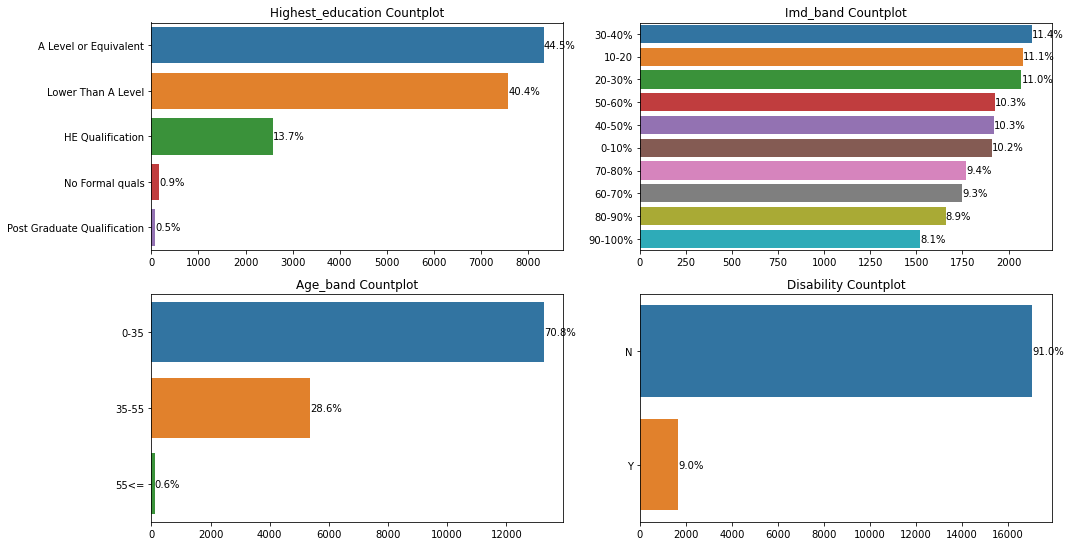

In [18]:
# Set the plot number for the first subplot function
plot_number = 1

# Set sizes for all plots
plt.figure(figsize=(15, 15)) # create a figure object
plt.subplots_adjust(hspace = 0.5) # set the size of subplots

for col in df_cat[['highest_education', 'imd_band', 'age_band', 'disability']]:
    
    # Call countplot on each column
    plt.subplot(4, 2, plot_number)
    sns.countplot(
        y=col,
        data=df_cat,
        order=df_cat[col].value_counts().index
    )
    plt.title(f'{col.capitalize()} Countplot')
    plt.xlabel('')
    plt.ylabel('')

    plot_number = plot_number + 1 # set a new plot number for the next subplot function
    
    # Add relative frequency labels:
    n_points = df_cat.shape[0]
    col_counts = df_cat[col].value_counts()
    locs, labels = plt.yticks()   # get the current tick locations and labels

    # loop through each pair of locations and labels
    for loc, label in zip(locs, labels):

        # get the text property for the label to get the correct count
        count = col_counts[label.get_text()]
        pct_string = '{:0.1f}%'.format(100*count/n_points)

        # print the annotation at the top of the bar
        plt.text(x=count, y=loc, s=pct_string, ha='left', va='center', color='k')
    
plt.tight_layout()

Edukasi para siswa berbeda tipis antara siswa yang sudah cukup dengan level modul dan lebih rendah dari level modul. Hal ini mungkin bisa terlihat dari imd_band yaitu tingkat kebobrokan wilayah beradarkan tempat tinggal mereka dimana 3 teratas memiliki tingkat keborokan antara 10-40 %. Tentu saja mayoritas umur yang wajar dalam universitas dimana umur terbanyak berada pada range 0-35, dan ternyata terdapat 9% student yang disabilitas

Sekarang mari kita lihat bagimana corelasi antar feature dengan target.

## Bivariate analysis: final scores vs other variables

### Numerical

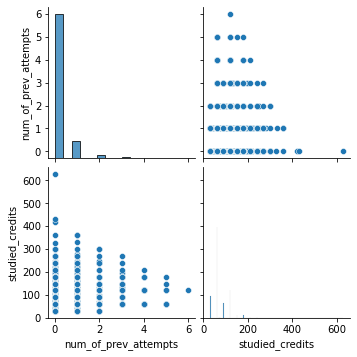

In [19]:
sns.pairplot(df)

### Categorical

#### code_module & code_presentation

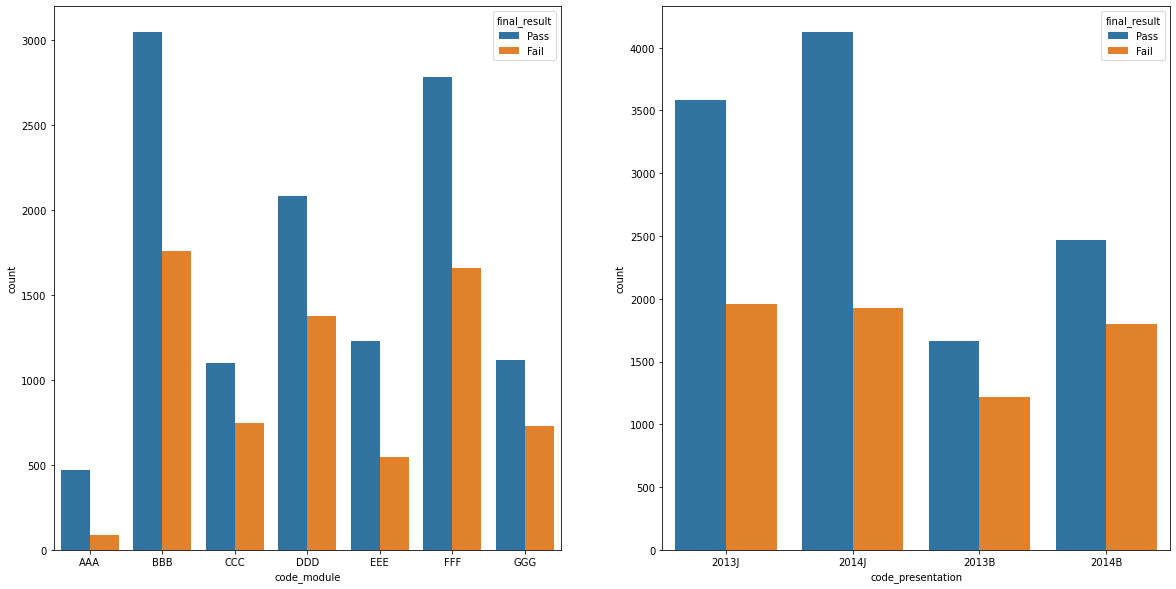

In [20]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
sns.countplot(data=df, x='code_module' ,hue='final_result')

plt.subplot(1,2,2)
sns.countplot(data=df, x='code_presentation' ,hue='final_result')
plt.show()

Memang modul BBB bisa dibilang modul yang terending karena banyak student yang mengambil module tersebut begitu pula dengan hasil kelulusan mereka dimana banyak yang berhasil dari module ini dan banyak juga yang tidak berhasil.

#### gender & region

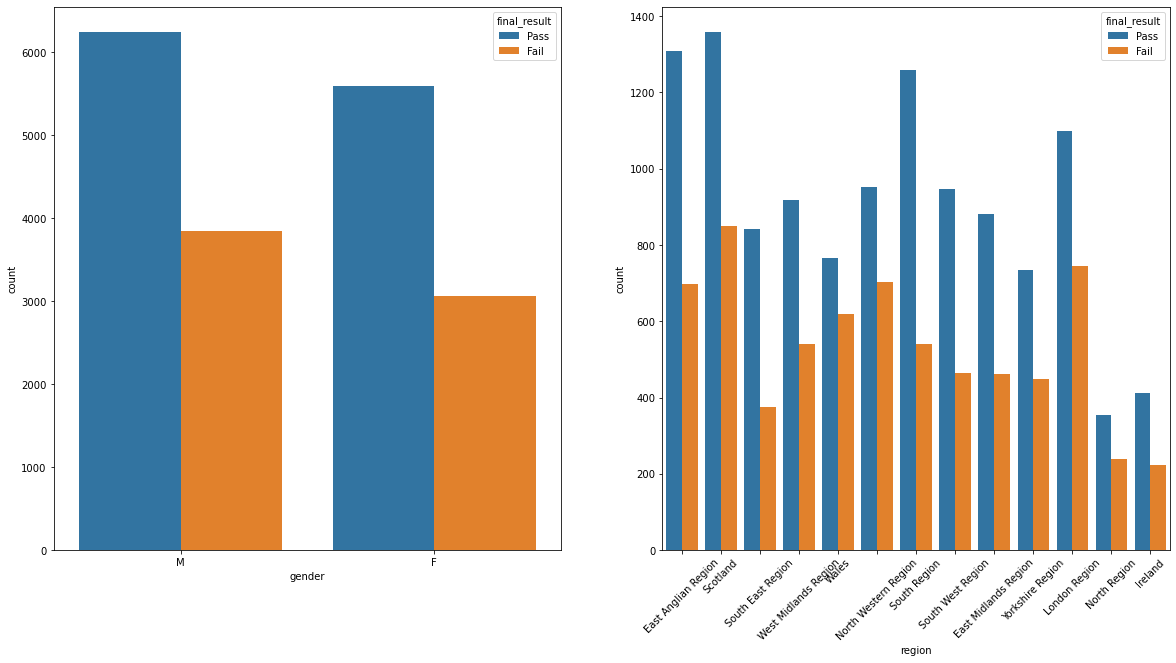

In [21]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
sns.countplot(data=df, x='gender' ,hue='final_result')

plt.subplot(1,2,2)
sns.countplot(data=df, x='region' ,hue='final_result')
plt.xticks(rotation=45)
plt.show()

Region Scotland memangkan perikat dimana region dengan student yang paling banyak lulus dan student yang paling banyak tidak lulusnya

#### highest_education & disability

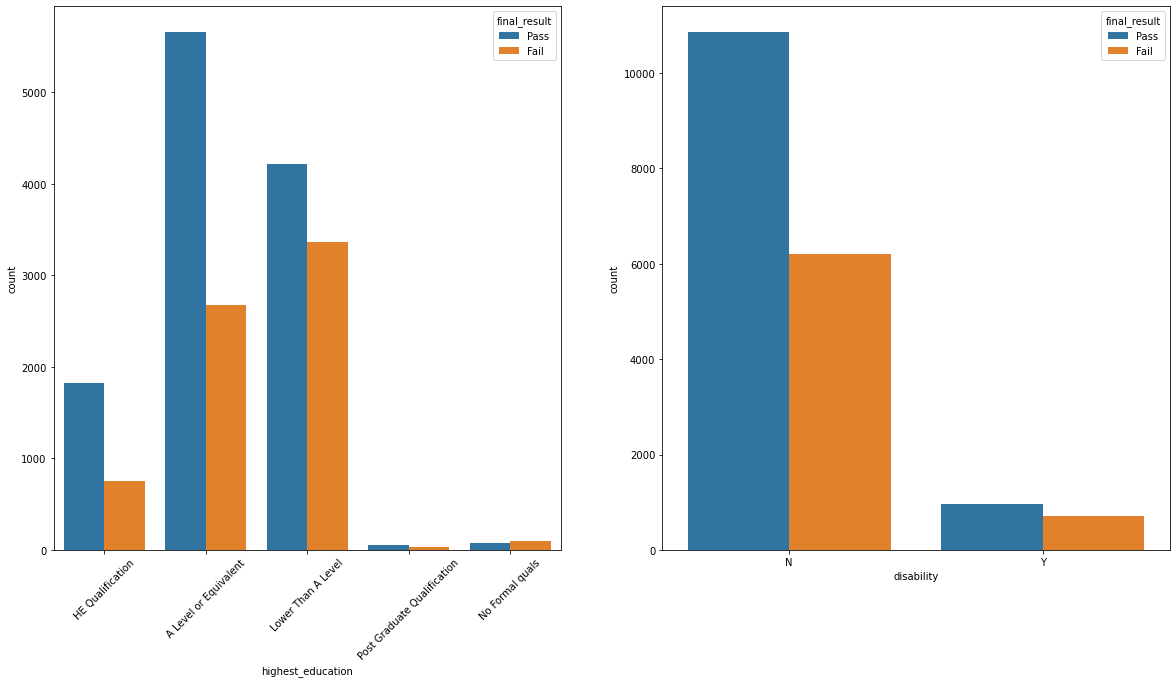

In [22]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
sns.countplot(data=df, x='highest_education' ,hue='final_result')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.countplot(data=df, x='disability' ,hue='final_result')
plt.show()

cukup mengejutkan bahwa student yang paling banyak lulus merupakan student dengan edukasi yang belum setara dengan universitas

#### imd_band & age_band

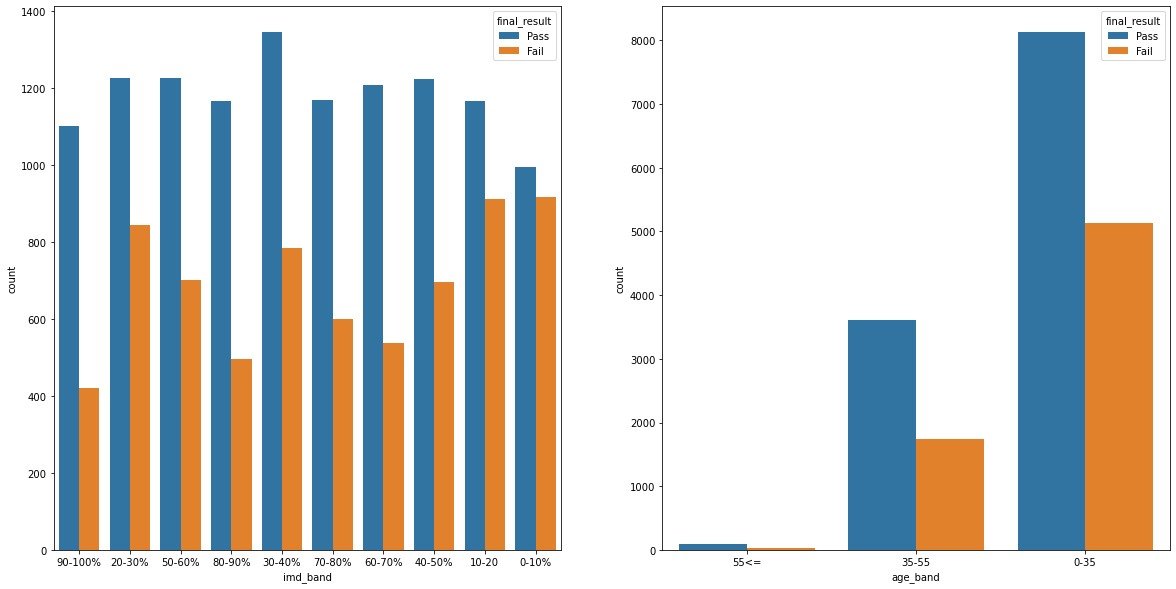

In [23]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
sns.countplot(data=df, x='imd_band' ,hue='final_result')

plt.subplot(1,2,2)
sns.countplot(data=df, x='age_band' ,hue='final_result')
plt.show()

Memang tempat belum tentu membuat kita berhasil terlihat dimana wilayah yang memiliki tingkat kebobrokan paling rendah yaitu range 0-10% bukanlah student yang paling banyak lulus, bisa dilihat dari grafik bahwa tingkat kebobrokan menengah yang paling banyak lulus.

Kita akan memasuki tahap data processing dimana berikut langkah yang dilakukan
- Feature Selection
- Split Data
- Detech Outliers
- Scaling & Encoding

# 5 - Data Preprocessing

## Feature Selection

Mari kita cek unique values dari setiap kolom

In [24]:
for i in df :
    print(f'{i} : {df[i].unique()}')

code_module : ['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
code_presentation : ['2013J' '2014J' '2013B' '2014B']
gender : ['M' 'F']
region : ['East Anglian Region' 'Scotland' 'South East Region'
 'West Midlands Region' 'Wales' 'North Western Region' 'South Region'
 'South West Region' 'East Midlands Region' 'Yorkshire Region'
 'London Region' 'North Region' 'Ireland']
highest_education : ['HE Qualification' 'A Level or Equivalent' 'Lower Than A Level'
 'Post Graduate Qualification' 'No Formal quals']
imd_band : ['90-100%' '20-30%' '50-60%' '80-90%' '30-40%' '70-80%' '60-70%' '40-50%'
 '10-20' '0-10%']
age_band : ['55<=' '35-55' '0-35']
num_of_prev_attempts : [0 1 2 4 3 5 6]
studied_credits : [240  60 120  90 150 180 420 170  80 300 210  75 135  70 225 325 130 195
 105 330 270 165 250  30  40  45 160 145 630 100 220 110  95 280 155 190
 200 215  55  50 115  65 140 360 430]
disability : ['N' 'Y']
final_result : ['Pass' 'Fail']


kolom region memiliki nilai yang lumayan jauh jumlah dibandingkan kolom yang lain untuk itu kita tidak akan memakai kolum tersebut supaya cardinality dari data tidak tinggi

In [25]:
df.drop('region', axis=1, inplace=True)

C:\Users\mjrum\AppData\Local\Temp\ipykernel_9548\713470462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('region', axis=1, inplace=True)


## Split Data

### Inference Data 

In [26]:
# Sample the data for inference Model
df_inf = df.sample(113, random_state=1)

# Drop df_inf data from df
df.drop(df_inf.index)

# reset the index
df.reset_index(drop=True, inplace=True)
df_inf.reset_index(drop=True, inplace=True)

df_inf

,code_module,code_presentation,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,BBB,2013J,M,A Level or Equivalent,80-90%,35-55,0,60,N,Pass
1,EEE,2014J,M,Lower Than A Level,30-40%,35-55,0,90,N,Pass
2,BBB,2013J,F,HE Qualification,50-60%,35-55,0,120,N,Fail
3,AAA,2014J,M,A Level or Equivalent,70-80%,35-55,0,60,N,Pass
4,BBB,2014B,F,Lower Than A Level,30-40%,0-35,0,90,N,Fail
...,...,...,...,...,...,...,...,...,...,...
108,FFF,2013B,M,Lower Than A Level,10-20,0-35,0,60,N,Fail
109,BBB,2014J,F,Lower Than A Level,10-20,0-35,0,60,Y,Pass
110,BBB,2014J,M,A Level or Equivalent,70-80%,0-35,0,120,N,Pass
111,DDD,2013J,M,A Level or Equivalent,20-30%,0-35,0,60,N,Pass


### Train & Test Data

In [27]:
# split feautures and target
X = df.drop(['final_result'], axis=1)
y = df['final_result']

# split features and target for Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# print shape
print(X_train.shape)
print(X_test.shape)

(14052, 9)
(4685, 9)


## Outliers

In [28]:
# Input Paramater Distribution  Check
dist_check = X_train.skew(numeric_only=True)

normal_dist = []
skew_dist = []

for i in range(len(dist_check)):
    if dist_check.values[i] < -0.5:
        skew_dist.append(dist_check.index[i])
    elif dist_check.values[i] > 0.5:
        skew_dist.append(dist_check.index[i])
    else:
        normal_dist.append(dist_check.index[i])

In [29]:
# Skew dist
print('skew_dist :', skew_dist)
print("__________"*20)
# normal_dist
print('normal_dist :',normal_dist)
print("__________"*20)

skew_dist : ['num_of_prev_attempts', 'studied_credits']
________________________________________________________________________________________________________________________________________________________________________________________________________
normal_dist : []
________________________________________________________________________________________________________________________________________________________________________________________________________


In [30]:
# Outliers Detection Function
# for Skew Distributed Data

def detect_skew(df, parameter, fold=1.5):
    
    for i in parameter:
        
        IQR = df[parameter].quantile(0.75) - df[parameter].quantile(0.25)
        upper = df[parameter].quantile(0.75) + (fold*IQR)
        bottom = df[parameter].quantile(0.25) - (fold*IQR)

        upper_count = df[
            (df[parameter] > upper)
        ][parameter].count()

        bottom_count = df[
            (df[parameter] < bottom)
        ][parameter].count()
        
        total_count = upper_count + bottom_count

        percentage = (total_count/len(df[parameter])*100).round(2)

        a = ({'Parameter':parameter, 'Total Outliers':total_count, 'Percentage':percentage})

    return print(a)

In [31]:
# Outlier summary
# For skew distributed input parameter

for i in skew_dist:
    detect_skew(X_train, parameter=i)

{'Parameter': 'num_of_prev_attempts', 'Total Outliers': 1820, 'Percentage': 12.95}
{'Parameter': 'studied_credits', 'Total Outliers': 687, 'Percentage': 4.89}


## Scaling & Encoding

In [32]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_ohe = ['code_module', 'code_presentation', 'gender', 'disability']
cat_ohe_label = ['AAA','BBB','CCC','DDD','EEE','FFF','GGG',
                '2013J','2014J','2013B','2014B','M','F','N','Y']
cat_ord = ['highest_education', 'imd_band', 'age_band']

In [33]:
scaler_encode = make_column_transformer(
    (MinMaxScaler(),num_cols),
    (OneHotEncoder(), cat_ohe),
    (OrdinalEncoder(), cat_ord),
)

Kita membuat column_transformer untuk memudahkan kita melakukan scaling dan encoding, terdapat 3 bagian dimana untuk kolom numeric kita menggunakan MinMaxScaler karena kolom numeric kita skew, lalu untu data yang non ordinal kita menggunakan OnehotEncoder dan data ordinal kita menggunakan OrdinalEncoder

# 6 - Model Definition

Pada klasifikasi ini kita menggunakan 4 Algoritma dimana 2 diantaranya adalah Ensamble.

Algoritma :
- Random Forest
- Decision Tree
- Support Vector Machine
- AdaBoost

Target : final_result

Feature : 
- code_module, code_presentation, gender, disability
- highest_education, imd_band, age_band
- studied_credits, num_of_prev_attempts

Kita menaruh Positive ketika melihat ConfussionMatix pada label Pass seperti pada objektive kita, lalu untuk mengetahui performanya kita akan melihat recallnya kaarena resiko akan lebih jika model salah memprediksi student yang sebenatnya lulus namun tdiprediksi tidak lulus.

Metrics :
- ConfussionMatrix
- Recall

## Random Forrest

In [34]:
random_state = 8
# Initial Model
RF = RandomForestClassifier(random_state=random_state, n_jobs=-1, verbose=1)

# Model Pipeline
pipe_RF = Pipeline([
    ('preprocessing', scaler_encode),
    ('RF', RF)
])

# Hyper parameter
params_RF = {
    'RF__criterion': ['gini', 'entropy'],
    'RF__min_samples_split': [2, 4, 8, 16, 32, 64],
    'RF__max_features': ['auto', 'sqrt', 'log2']
}

## Decission Tree

In [35]:
# Initial Model
DT = DecisionTreeClassifier(random_state=random_state)

# Model Pipeline
pipe_DT = Pipeline([
    ('preprocessing', scaler_encode),
    ('DT', DT)
])

# Hyper parameter
params_DT = {
    'DT__criterion': ['gini', 'entropy'],
    'DT__max_depth': [None, 8, 16, 32],
    'DT__min_samples_split': [2, 4, 8, 16, 32, 64]
}

## SVM

In [36]:
# Initial Model
SVM = SVC(random_state=random_state)

# Model Pipeline
pipe_SVM = Pipeline([
    ('preprocessing', scaler_encode),
    ('SVM', SVM)
])

# Hyper parameter
params_SVM = {'SVM__C': [100,1000],
              'SVM__gamma': [ 0.01,0.001],
              'SVM__kernel': ['rbf']}

## AdaBoost

In [37]:
# Initial Model
Ada = AdaBoostClassifier(random_state=random_state)

# Model Pipeline
pipe_Ada = Pipeline([
    ('preprocessing', scaler_encode),
    ('Ada', Ada)
])

# Hyper parameter
params_Ada = {
    'Ada__n_estimators': [10, 50, 100, 200, 500],
    'Ada__learning_rate': [0.1, 0.5, 1, 10, 50, 100],
    'Ada__algorithm': ['SAMME', 'SAMME.R']
}

# 7 - Model Training

Kita akan melakukan training kepada setiap model untuk melihat performanya satu satu lalu kita akan recap performanya menggunakan cross validation score yang tentunya scoring berdasarkan recall dimana positivenya adalah Pass. Setelah itu kita akan menentukan performa model terbaik untuk kita lakukan hyperparameter tuning menggunakan GridSearchCV.

## Base Model

### Random Forest

In [38]:
pipe_RF.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['num_of_prev_attempts',
                                                   'studied_credits']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['code_module',
                                                   'code_presentation',
                                                   'gender', 'disability']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['highest_education',
                                                   'imd_band', 'age_band'])])),
                ('RF',
                 RandomFore

### Decission Tree

In [39]:
pipe_DT.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['num_of_prev_attempts',
                                                   'studied_credits']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['code_module',
                                                   'code_presentation',
                                                   'gender', 'disability']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['highest_education',
                                                   'imd_band', 'age_band'])])),
                ('DT', DecisionTreeClassifier(rand

### SVM

In [40]:
pipe_SVM.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['num_of_prev_attempts',
                                                   'studied_credits']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['code_module',
                                                   'code_presentation',
                                                   'gender', 'disability']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['highest_education',
                                                   'imd_band', 'age_band'])])),
                ('SVM', SVC(random_state=8))])

### AdaBoost

In [41]:
pipe_Ada.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['num_of_prev_attempts',
                                                   'studied_credits']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['code_module',
                                                   'code_presentation',
                                                   'gender', 'disability']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['highest_education',
                                                   'imd_band', 'age_band'])])),
                ('Ada', AdaBoostClassifier(random_

## Cross-Validate

In [43]:
# Cross-validate base model

# prepare models and put it into list
models = []
models.append(('RF', pipe_RF))
models.append(('Ada', pipe_Ada))
models.append(('DT', pipe_DT))
models.append(('SVM', pipe_SVM))

# Create empty list to stores result
names = []
results = []
mean_score = []
stdev_score = []

recall = make_scorer(recall_score, pos_label="Pass")

# Cross-validate each model
for name, model in models:
    model.fit(X_train,y_train)
    scores = cross_val_score(model, X_train,y_train, scoring = recall, cv=5, n_jobs=-1)

    names.append(name)
    results.append(scores)
    mean_score.append(scores.mean())
    stdev_score.append(scores.std())

cv_result = pd.DataFrame({'models':names, 'mean_score':mean_score, 'stdev_score':stdev_score})

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


# 8 - Model Evaluation

## Predict Base Model

### Random Forest

In [44]:
# predict
y_train_pred_RF = pipe_RF.predict(X_train)
y_test_pred_RF = pipe_RF.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


#### Evaluation

In [45]:
# Function Plotting Conffusion Matrix
def plotConffusionMatrix(target, prediction, model):
    cm = confusion_matrix(target, prediction, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    plt.figure(figsize=(10,10))
    disp.plot(include_values=True, cmap='viridis')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def showClassificationReport(target_train, prediction_train, target_test, prediction_test):
    print('==================== Train Results ====================')
    print(classification_report(target_train,prediction_train))
    print('==================== Test Results ====================')
    print(classification_report(target_test,prediction_test))

Confusion Matrix for Train-set


<Figure size 720x720 with 0 Axes>

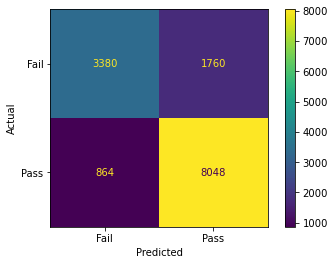

Confusion Matrix for Test-set


<Figure size 720x720 with 0 Axes>

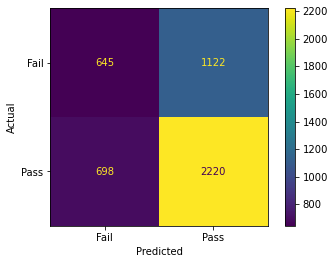

==================== Train Results ====================
              precision    recall  f1-score   support

        Fail       0.80      0.66      0.72      5140
        Pass       0.82      0.90      0.86      8912

    accuracy                           0.81     14052
   macro avg       0.81      0.78      0.79     14052
weighted avg       0.81      0.81      0.81     14052

==================== Test Results ====================
              precision    recall  f1-score   support

        Fail       0.48      0.37      0.41      1767
        Pass       0.66      0.76      0.71      2918

    accuracy                           0.61      4685
   macro avg       0.57      0.56      0.56      4685
weighted avg       0.59      0.61      0.60      4685



In [46]:
# Show Confussion Matrix and Classification Report for Train-set and Test-set
print('Confusion Matrix for Train-set')
plotConffusionMatrix(y_train,y_train_pred_RF,RF)
print('Confusion Matrix for Test-set')
plotConffusionMatrix(y_test,y_test_pred_RF,RF)
showClassificationReport(y_train,y_train_pred_RF,y_test,y_test_pred_RF)

Confussion Matrix

- Train 
TP : 8048 TN: 3380 FP : 1760 : FN : 864

- Test
TP : 2220 TN: 645 FP : 1122 : FN : 698

Recall:
Model overfitt terlihat recal pada train 90 dan test 76


#### Feature Importance

In [47]:
def showFeatureImportance(model):
    a = model.__getattribute__('feature_importances_')
    a = pd.DataFrame(a)
    a.sort_values(by=0, ascending=False, inplace=True)
    b = a.T
    b.rename(columns={0:'num_of_prev_attempts', 1: 'studied_credits',2:'AAA',
                3:'BBB',4:'CCC',5:'DDD',6:'EEE',7:'FFF',8:'GGG',9:'2013J',10:'2014J',
                11:'2013B',12:'2014B',13:'M',14:'F',15:'N',16:'Y',17:'highest_education',
                18:'imd_band',19:'age_band'}, inplace=True)
    a = b.T

    return a

In [48]:
showFeatureImportance(RF)

,0
imd_band,0.350771
studied_credits,0.205855
highest_education,0.093755
age_band,0.057062
num_of_prev_attempts,0.056538
DDD,0.020992
FFF,0.020869
BBB,0.020433
2014B,0.018166
2014J,0.017661


### Decision Tree

In [49]:
# predict
y_train_pred_DT = pipe_DT.predict(X_train)
y_test_pred_DT = pipe_DT.predict(X_test)

#### Evaluation

Confusion Matrix for Train-set


<Figure size 720x720 with 0 Axes>

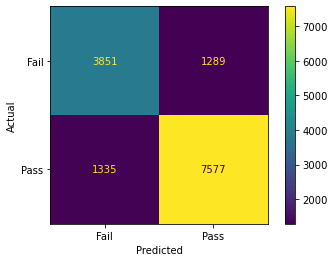

Confusion Matrix for Test-set


<Figure size 720x720 with 0 Axes>

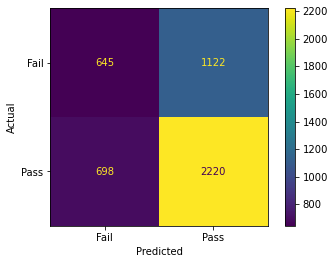

==================== Train Results ====================
              precision    recall  f1-score   support

        Fail       0.74      0.75      0.75      5140
        Pass       0.85      0.85      0.85      8912

    accuracy                           0.81     14052
   macro avg       0.80      0.80      0.80     14052
weighted avg       0.81      0.81      0.81     14052

==================== Test Results ====================
              precision    recall  f1-score   support

        Fail       0.44      0.45      0.44      1767
        Pass       0.66      0.65      0.66      2918

    accuracy                           0.57      4685
   macro avg       0.55      0.55      0.55      4685
weighted avg       0.58      0.57      0.58      4685



In [50]:
# Show Confussion Matrix and Classification Report for Train-set and Test-set
print('Confusion Matrix for Train-set')
plotConffusionMatrix(y_train,y_train_pred_DT,DT)
print('Confusion Matrix for Test-set')
plotConffusionMatrix(y_test,y_test_pred_RF,DT)
showClassificationReport(y_train,y_train_pred_DT,y_test,y_test_pred_DT)

Confussion Matrix

- Train 
TP : 7577 TN: 3851 FP : 1289 : FN : 1335

- Test
TP : 2220 TN: 698 FP : 1122 : FN : 698

Recall:
Model overfitt terlihat recal pada train 85 dan test 65

### SVM

In [51]:
# predict
y_train_pred_SVM = pipe_SVM.predict(X_train)
y_test_pred_SVM = pipe_SVM.predict(X_test)

#### Evaluation

Confusion Matrix for Train-set


<Figure size 720x720 with 0 Axes>

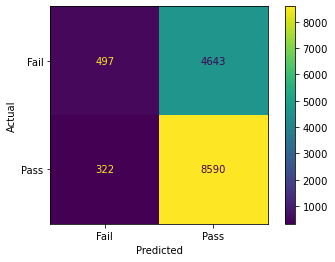

Confusion Matrix for Test-set


<Figure size 720x720 with 0 Axes>

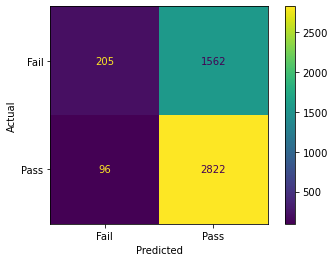

==================== Train Results ====================
              precision    recall  f1-score   support

        Fail       0.61      0.10      0.17      5140
        Pass       0.65      0.96      0.78      8912

    accuracy                           0.65     14052
   macro avg       0.63      0.53      0.47     14052
weighted avg       0.63      0.65      0.55     14052

==================== Test Results ====================
              precision    recall  f1-score   support

        Fail       0.68      0.12      0.20      1767
        Pass       0.64      0.97      0.77      2918

    accuracy                           0.65      4685
   macro avg       0.66      0.54      0.49      4685
weighted avg       0.66      0.65      0.56      4685



In [52]:
# Show Confussion Matrix and Classification Report for Train-set and Test-set
print('Confusion Matrix for Train-set')
plotConffusionMatrix(y_train,y_train_pred_SVM,SVM)
print('Confusion Matrix for Test-set')
plotConffusionMatrix(y_test,y_test_pred_SVM,SVM)
showClassificationReport(y_train,y_train_pred_SVM,y_test,y_test_pred_SVM)

Confussion Matrix

- Train 
TP : 8590 TN: 497 FP : 4643 : FN : 322

- Test
TP : 2822 TN: 205 FP : 1562 : FN : 96

Recall:
Model sudah goodfit terlihat recal pada train 96 dan test 97

### AdaBoost

In [53]:
# predict
y_train_pred_Ada = pipe_Ada.predict(X_train)
y_test_pred_Ada = pipe_Ada.predict(X_test)

#### Evaluation

Confusion Matrix for Train-set


<Figure size 720x720 with 0 Axes>

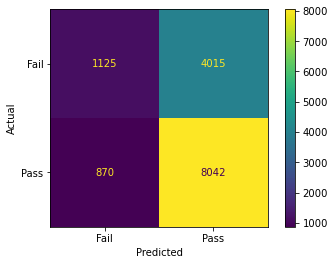

Confusion Matrix for Test-set


<Figure size 720x720 with 0 Axes>

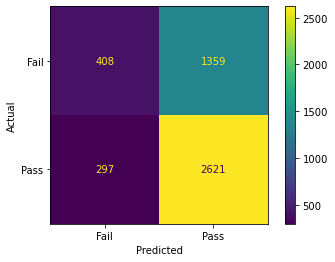

==================== Train Results ====================
              precision    recall  f1-score   support

        Fail       0.56      0.22      0.32      5140
        Pass       0.67      0.90      0.77      8912

    accuracy                           0.65     14052
   macro avg       0.62      0.56      0.54     14052
weighted avg       0.63      0.65      0.60     14052

==================== Test Results ====================
              precision    recall  f1-score   support

        Fail       0.58      0.23      0.33      1767
        Pass       0.66      0.90      0.76      2918

    accuracy                           0.65      4685
   macro avg       0.62      0.56      0.55      4685
weighted avg       0.63      0.65      0.60      4685



In [54]:
# Show Confussion Matrix and Classification Report for Train-set and Test-set
print('Confusion Matrix for Train-set')
plotConffusionMatrix(y_train,y_train_pred_Ada,Ada)
print('Confusion Matrix for Test-set')
plotConffusionMatrix(y_test,y_test_pred_Ada,Ada)
showClassificationReport(y_train,y_train_pred_Ada,y_test,y_test_pred_Ada)

Confussion Matrix

- Train 
TP : 8042 TN: 1125 FP : 4015 : FN : 870

- Test
TP : 2621 TN: 408 FP : 1359 : FN : 297

Recall:
Model sudah goodfit terlihat recal pada train 90 dan test 90

## Cross -Validate Result

In [55]:
# Showing the result
cv_result.sort_values(by='mean_score', ascending=False)

,models,mean_score,stdev_score
3,SVM,0.963758,0.006102
1,Ada,0.902381,0.012113
0,RF,0.725987,0.005727
2,DT,0.636333,0.006670


In [56]:
cv_result.sort_values(by='stdev_score', ascending=True)

,models,mean_score,stdev_score
0,RF,0.725987,0.005727
3,SVM,0.963758,0.006102
2,DT,0.636333,0.006670
1,Ada,0.902381,0.012113


Terlihat bahwa kita kita fit dengan scroos validation model SVM yang mungkin paling bagus.
Untuk itu marikita tunning hyperparameter dari setiap algortima SVM dan mari kita coba algoritma Random Forest

## Hyperparameter Tunning

### Random Forest

In [57]:
# Hyperparameter tuning
grid_RF = GridSearchCV(pipe_RF, params_RF, cv=5, n_jobs=-1, verbose=1, refit=False)

grid_RF.fit(X_train, y_train)

best_params_RF = grid_RF.best_params_
df_result_RF = pd.DataFrame.from_dict(grid_RF.cv_results_, orient='columns')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [58]:
best_params_RF

{'RF__criterion': 'gini',
 'RF__max_features': 'auto',
 'RF__min_samples_split': 64}

#### Predict with best parameter

In [59]:
RF_hyper = RandomForestClassifier(criterion='gini', max_features='auto', min_samples_leaf=64, random_state=8)

# Model Pipeline
pipe_RF_hyper = Pipeline([
    ('preprocessing', scaler_encode),
    ('RF', RF_hyper)
])

In [60]:
pipe_RF_hyper.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['num_of_prev_attempts',
                                                   'studied_credits']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['code_module',
                                                   'code_presentation',
                                                   'gender', 'disability']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['highest_education',
                                                   'imd_band', 'age_band'])])),
                ('RF',
                 RandomFore

In [61]:
y_train_pred_RF_hyper = pipe_RF_hyper.predict(X_train)
y_test_pred_RF_hyper = pipe_RF_hyper.predict(X_test)

#### Evaluation

Confusion Matrix for Train-set


<Figure size 720x720 with 0 Axes>

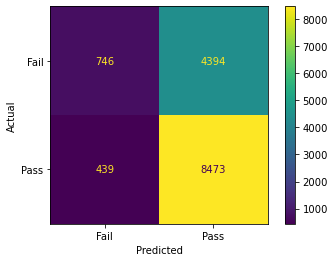

Confusion Matrix for Test-set


<Figure size 720x720 with 0 Axes>

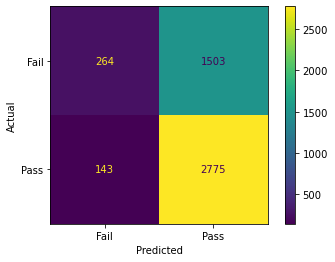

==================== Train Results ====================
              precision    recall  f1-score   support

        Fail       0.63      0.15      0.24      5140
        Pass       0.66      0.95      0.78      8912

    accuracy                           0.66     14052
   macro avg       0.64      0.55      0.51     14052
weighted avg       0.65      0.66      0.58     14052

==================== Test Results ====================
              precision    recall  f1-score   support

        Fail       0.65      0.15      0.24      1767
        Pass       0.65      0.95      0.77      2918

    accuracy                           0.65      4685
   macro avg       0.65      0.55      0.51      4685
weighted avg       0.65      0.65      0.57      4685



In [62]:
# Show Confussion Matrix and Classification Report for Train-set and Test-set
print('Confusion Matrix for Train-set')
plotConffusionMatrix(y_train,y_train_pred_RF_hyper,RF_hyper)
print('Confusion Matrix for Test-set')
plotConffusionMatrix(y_test,y_test_pred_RF_hyper,RF_hyper)
showClassificationReport(y_train,y_train_pred_RF_hyper,y_test,y_test_pred_RF_hyper)

Confussion Matrix

- Train 
TP : 8473 TN: 746 FP : 4394 : FN : 439

- Test
TP : 2775 TN: 264 FP : 1503 : FN : 143

Terlihat model semakin baik menangai FN nya dimana FN mengalami penurunan dari base Moeel


Recall:
Model mengalami perubahan dimana pada base model 
model overfit namun setelah hyperparameter tunning model overfitt terlihat reccal train 95 dan recal test 95

### SVM

In [63]:
# Hyperparameter tuning
grid_SVM = GridSearchCV(pipe_SVM, params_SVM, cv=5, n_jobs=-1, verbose=1, refit=False)

grid_SVM.fit(X_train, y_train)

best_params_SVM = grid_SVM.best_params_
df_result_SVM = pd.DataFrame.from_dict(grid_SVM.cv_results_, orient='columns')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [64]:
best_params_SVM

{'SVM__C': 1000, 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf'}

#### Predict with best parameter

In [65]:
SVM_hyper = SVC(random_state=random_state, C=1000, kernel='rbf', gamma=0.01)

pipe_SVM_hyper = Pipeline([
    ('preprocessing', scaler_encode),
    ('SVM_hyper', SVM_hyper)
])

In [66]:
pipe_SVM_hyper.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['num_of_prev_attempts',
                                                   'studied_credits']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['code_module',
                                                   'code_presentation',
                                                   'gender', 'disability']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['highest_education',
                                                   'imd_band', 'age_band'])])),
                ('SVM_hyper', SVC(C=1000, gamma=0.

In [67]:
y_train_pred_SVM_hyper = pipe_SVM_hyper.predict(X_train)
y_test_pred_SVM_hyper = pipe_SVM_hyper.predict(X_test)

#### Evaluation

Confusion Matrix for Train-set


<Figure size 720x720 with 0 Axes>

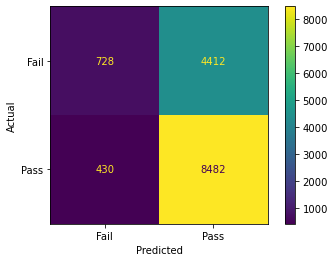

Confusion Matrix for Test-set


<Figure size 720x720 with 0 Axes>

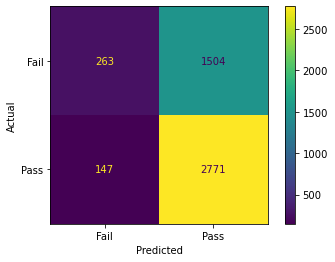

==================== Train Results ====================
              precision    recall  f1-score   support

        Fail       0.63      0.14      0.23      5140
        Pass       0.66      0.95      0.78      8912

    accuracy                           0.66     14052
   macro avg       0.64      0.55      0.50     14052
weighted avg       0.65      0.66      0.58     14052

==================== Test Results ====================
              precision    recall  f1-score   support

        Fail       0.64      0.15      0.24      1767
        Pass       0.65      0.95      0.77      2918

    accuracy                           0.65      4685
   macro avg       0.64      0.55      0.51      4685
weighted avg       0.65      0.65      0.57      4685



In [68]:
# Show Confussion Matrix and Classification Report for Train-set and Test-set
print('Confusion Matrix for Train-set')
plotConffusionMatrix(y_train,y_train_pred_SVM_hyper,SVM_hyper)
print('Confusion Matrix for Test-set')
plotConffusionMatrix(y_test,y_test_pred_SVM_hyper,SVM_hyper)
showClassificationReport(y_train,y_train_pred_SVM_hyper,y_test,y_test_pred_SVM_hyper)

Confussion Matrix

- Train 
TP : 8482 TN: 728 FP : 4412 : FN : 728

- Test
TP : 2771 TN: 263 FP : 1504 : FN : 147

Terlihat model malah malah semakin turun performanya dalam menangani FNnya dimana pada base Model FN pada Train set 322 namun setelah hyperparameter tunning FN bertambah jadi 728
begitu juga dengan testnya.


Recall:
Terlihat dai recallnya yagn turun dari base model namun memang sudah good fit

Bedasarkan analisis yang kita lihat objective kita adalah mencari model yang baik dalam menangani kasus ketika model salah memprediksi student yang sebenenarnya lulus tapi terprediksi tidak lulus.

Maka Random Forest merupakan algoritma yang terbaik yang sesuai dengan objective kita.

Untuk itu marik kita lakukan Model Inference untuk melihat bagaimana model terhadap data baru

## Saving Model

In [ ]:
with open('RF_hyper.pkl', 'wb') as f:
    pickle.dump(pipe_RF_hyper, f)

# 9 - Model Inference

## Load Model

In [69]:
# load Model
with open('RF_hyper.pkl', 'rb') as f:
    rf_model = pickle.load(f)

## Inference

In [70]:
X_inf = df_inf.drop(['final_result'], axis=1)
y_inf = df_inf['final_result']

In [72]:
y_pred_inf = rf_model.predict(X_inf)

Confusion Matrix for Train-set


<Figure size 720x720 with 0 Axes>

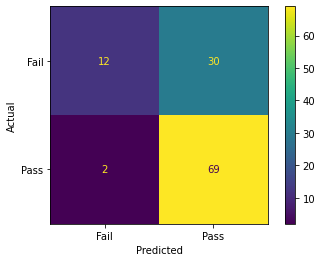

In [73]:
print('Confusion Matrix for Train-set')
plotConffusionMatrix(y_inf,y_pred_inf,rf_model)

Masing terlihat jika terdapat 33 siswa yang terprediksi salah, untuk itu model masih bisa dilakukan training lebih baik lagi.

# 10 - Pengambilan Kesimpulan

## Hasil EDA
- Setelah kita memilih target kita , kita bisa melihat bahwa terdapat 19413 baris dan 11 kolom .
Semua attribut adalah object kecuali kolom **id_student**, **num_of_prev_attempts**, dan **studied_credits**. 
Terlihat juga bahwa semua colum terisi sesui dengan banyaknya baris yang mengindikasi tidak ada Missing Values. 

- id_student, mungkin berfungsi sebagai index, karena pada dasarnya setiap student pasti berbeda idnya

    number_of_prev_attempts, terlihat dari 25%, 50%, dan 75% quartile bernilai 0 dimana bisa diasumsikan student baru pertama kali mengikuti module namun terdappat juga student yang sudah 6 kali mengambil modul tertentu terlihat dari nilai maxnya

    studied_credits, student memiliki rata-rata 74 credit , yang dangat jauh dari student yang memiliki credits tertinggi yaitu 630.

    Mari kita cek apakah terdapat baris yang terduplikat pada data ini.

- Terlihat perbedaan yang lumayan signifikan antara student yang lulus dengan yang tidak dimana student yang lulus ada 63,7% dan student yang tidak lulus terdapat 36,3%.

- Untuk kolom numerik ternyata berdistribusi skew terlihatt data berkumpul disebelah kiri. 
Mayoritas student juga merupakan student yang baru pertama kali mengambil module yang mereka ambil . Credit student mayoritas juga berada pada range 0 - 200.

- Module BBB merupakan module yang paling banyak di ambil oleh student dimana presentasi 2014j yang paling banyak diambil. Student juga lebih banyak pria dibanding wanita. 
Tempat tinggal Student yang mengikuti module paling banyak dari region scotlandia dan paling sedikit berada di Ireland dan North Region

- Edukasi para siswa berbeda tipis antara siswa yang sudah cukup dengan level modul dan lebih rendah dari level modul. Hal ini mungkin bisa 
terlihat dari imd_band yaitu tingkat kebobrokan wilayah beradarkan tempat tinggal mereka dimana 3 teratas memiliki tingkat keborokan antara 10-40 %. 
Tentu saja mayoritas umur yang wajar dalam universitas dimana umur terbanyak berada pada range 0-35, dan ternyata terdapat 9% student yang disabilitas

- Memang modul BBB bisa dibilang modul yang terending karena banyak student yang mengambil 
module tersebut begitu pula dengan hasil kelulusan mereka dimana banyak yang berhasil dari module ini dan banyak juga yang tidak berhasil.

- Region Scotland memangkan perikat dimana region dengan student yang paling banyak lulus dan student yang paling banyak tidak lulusnya

- cukup mengejutkan bahwa student yang paling banyak lulus merupakan student dengan edukasi yang belum setara dengan universitas

- Memang tempat belum tentu membuat kita berhasil terlihat dimana wilayah yang memiliki tingkat kebobrokan paling rendah yaitu range 
0-10% bukanlah student yang paling banyak lulus, bisa dilihat dari grafik bahwa tingkat kebobrokan menengah yang paling banyak lulus.


## Hasil Model

- Pada Training menggunakan base parameter dan kita lakukan cross validaion kita mendapatkan bahwa model SVM merupakan model yang mendekati objektif, namun kita melihat ketika kita training satu-satu modelnya dengan tetap base parameter kita mendapatkan model SVM memang cukup baik namun model Random Forest juga cukup baik namun masih overfit memang.

SVM Base Model

    Confussion Matrix

    - Train 
    TP : 8590 TN: 497 FP : 4643 : FN : 322

    - Test
    TP : 2822 TN: 205 FP : 1562 : FN : 96

    Recall:
    Model sudah goodfit terlihat recal pada train 96 dan test 97

Random Forest Base Model

    - Train 
    TP : 8048 TN: 3380 FP : 1760 : FN : 864

    - Test
    TP : 2220 TN: 645 FP : 1122 : FN : 698

    Recall:
    Model overfitt terlihat recal pada train 90 dan test 76

Untuk itu kita melakukan hyper parameter Tunning pada kedua model dan menemukan bahwa model SVM mengalami penurunan performa sedangkan model Random Forrest Mengalami kenaikan performa dan menjadi goodfit model

SVM Hyperparameter

Confussion Matrix

    - Train 
    TP : 8482 TN: 728 FP : 4412 : FN : 728

    - Test
    TP : 2771 TN: 263 FP : 1504 : FN : 147

    Terlihat model malah malah semakin turun performanya dalam menangani FNnya dimana pada base Model FN pada Train set 322 namun setelah hyperparameter tunning FN bertambah jadi 728
    begitu juga dengan testnya.

Random Forrest HyperParameter

Confussion Matrix

    - Train 
    TP : 8473 TN: 746 FP : 4394 : FN : 439

    - Test
    TP : 2775 TN: 264 FP : 1503 : FN : 143

    Terlihat model semakin baik menangai FN nya dimana FN mengalami penurunan dari base Moeel


    Recall:
    Model mengalami perubahan dimana pada base model 
    model overfit namun setelah hyperparameter tunning model overfitt terlihat reccal train 95 dan recal test 95

Untuk itu kita bisa menyimpulkan bahwa model Random Forrest yang terbaik sesuai objektif kita